# Prepare

In [1]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from typing import Union, List
from enum import Enum
import json

from PIL import Image
import numpy as np

import torch
from torchvision import transforms
import torchvision.models as models

import matplotlib.pyplot as plt

import pytorch_grad_cam as cam
import pytorch_grad_cam.utils as utils
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
class CAMType(Enum):
    GRAD_CAM = cam.GradCAM
    HI_RES_CAM = cam.HiResCAM
    GRAD_CAM_ELEMENT_WISE = cam.GradCAMElementWise
    ABLATION_CAM = cam.AblationCAM
    X_GRAD_CAM = cam.XGradCAM
    GRAD_CAM_PLUS_PLUS = cam.GradCAMPlusPlus
    SCORE_CAM = cam.ScoreCAM
    LAYER_CAM = cam.LayerCAM
    EIGEN_CAM = cam.EigenCAM
    EIGEN_GRAD_CAM = cam.EigenGradCAM
    KPCA_CAM = cam.KPCA_CAM
    RANDOM_CAM = cam.RandomCAM
    FULL_GRAD = cam.FullGrad

def get_cam(cam_type: CAMType, model: torch.nn.Module, target_layers: torch.nn.Module):
    cam_class = cam_type.value
    return cam_class(model=model, target_layers=target_layers)

def visualize(grayscale: torch.Tensor, rgb_img: np.ndarray):
    visualization = show_cam_on_image(rgb_img, grayscale, use_rgb=True)
    plt.imshow(visualization)
    plt.axis('off')
    plt.show()

def display_images_in_rows(rgb_img: np.ndarray, grayscale_list: List[torch.Tensor], labels: List[str]):
    """
    Displays a list of images in rows, with each row containing up to max_images_per_row images.
    
    Args:
        images (list of np.ndarray): List of images to display.
        labels (list of str): List of labels for each image.
        max_images_per_row (int): Maximum number of images per row (default is 4).
    """

    images = [rgb_img]

    for grayscale in grayscale_list:
        images.append(show_cam_on_image(rgb_img, grayscale, use_rgb=True))

    labels.insert(0, "Image")

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # Loop through the images and labels to display them
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img)  # Show the image
        ax.set_title(label)  # Set the title
        ax.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

def execute_cam(
        img_path: str,
        model: torch.nn.Module,
        target_layers: List[torch.nn.Module],
        cam_type: CAMType,
        targets: Union[List[ClassifierOutputTarget], None] = None,
        visualization: bool = False,
        output_path: Union[str, None] = None
    ):
        model_name = "unknown"
        target_layer_name = "unknown"
        try:
            model_name = model._get_name()
            target_layer_name = target_layers[0]._get_name()
        except:
            pass

        print(f"Executing CAM on {model_name} with target layer {target_layer_name}:")

        img = np.array(Image.open(img_path).convert("RGB"))
        img = cv2.resize(img, (224, 224))
        img = np.float32(img) / 255
        input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        # Forward to get target class if not specified
        if not targets:
            with torch.no_grad():
                predicted_class = model(input_tensor).max(1)[-1]
                targets = [ClassifierOutputTarget(predicted_class)]
                print(predicted_class)
                print(f"Target class: {labels[str(predicted_class.item())][1]}")

        cam = get_cam(cam_type=cam_type, model=model, target_layers=target_layers)

        # Generate the CAM
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

        # Overlay the CAM on the image
        if visualization:
            # Convert the PIL image to a NumPy array for visualization
            rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0  # Normalize the pixel values
            
            visualize(grayscale=grayscale_cam[0, :], rgb_img=rgb_img)

            # Optionally, you can save the resulting CAM visualization
            if output_path:
                Image.fromarray((visualization * 255).astype(np.uint8)).save(output_path)
                print(f"Saved output image to {output_path}")

        return grayscale_cam, input_tensor

labels = json.load(open("../pytorch_grad_cam/utils/imagenet_class_index.json"))

# Body

## Calculate increase in confidence

Executing CAM on ResNet with target layer Sequential:
tensor([270])
Target class: white_wolf


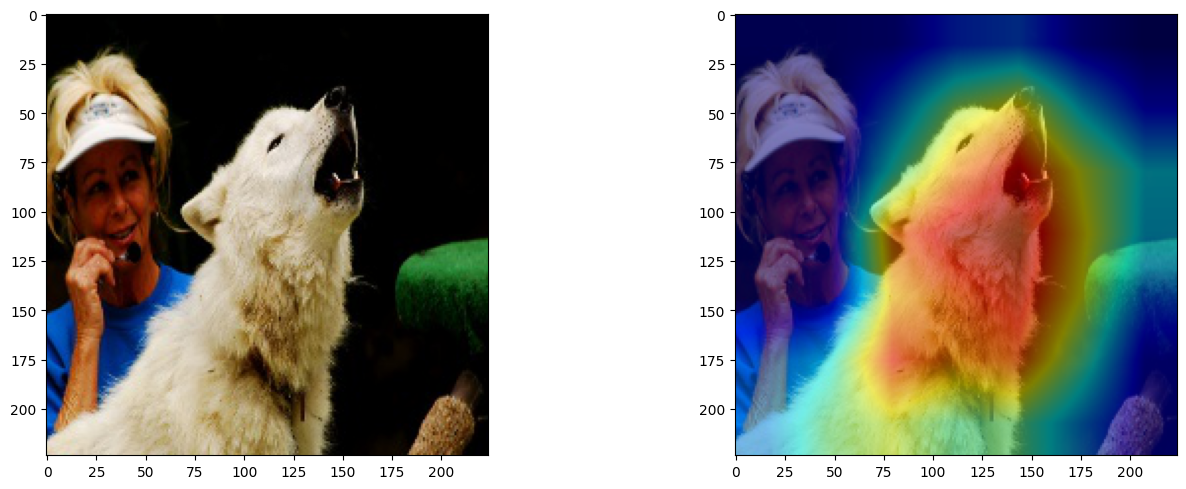

In [3]:
model = models.resnet50(pretrained=True).eval()
target_layers = [model.layer4]

cam_type = CAMType.GRAD_CAM
img_path = "../images/ILSVRC2012_val_00000091.JPEG"
gray_scale, input_tensor = execute_cam(img_path=img_path, model=model, target_layers=target_layers, cam_type=cam_type)
rgb_img = Image.open(img_path).convert('RGB')
rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0
img_saliency = show_cam_on_image(rgb_img, gray_scale[0, :], use_rgb=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(rgb_img)
axes[1].imshow(img_saliency)

plt.tight_layout()
plt.show()

The confidence increase percent: [4.1411676]%
The visualization of the pertubated image for the metric:


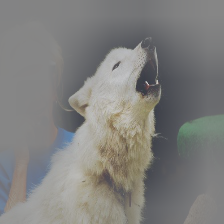

In [4]:
predicted_class = model(input_tensor).max(1)[-1]
targets = [ClassifierOutputTarget(predicted_class)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, gray_scale, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {score}%")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

## Average drop & Average increase

In [5]:
import os
from PIL import Image
import numpy as np
import torch
from pytorch_grad_cam.metrics.cam_mult_image import DropInConfidence, IncreaseInConfidence

# Initialize model, GradCAM configurations, and metrics
model = models.resnet50(pretrained=True).eval()
target_layers = [model.layer4]
cam_type = CAMType.GRAD_CAM
cam_metric = CamMultImageConfidenceChange()

# Initialize metrics to calculate averages
drop_in_conf_metric = DropInConfidence()
increase_in_conf_metric = IncreaseInConfidence()

total_drop_in_conf = 0
total_increase_in_conf = 0
num_images = 0  # to keep track of number of processed images

folder_path = "../images"
for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.JPEG', '.png')):
        img_path = os.path.join(folder_path, filename)

        # Execute CAM for the current image
        gray_scale, input_tensor = execute_cam(img_path=img_path, model=model, target_layers=target_layers, cam_type=cam_type)
        
        # Load and preprocess the image for CAM overlay
        rgb_img = Image.open(img_path).convert('RGB')
        rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0
        img_saliency = show_cam_on_image(rgb_img, gray_scale[0, :], use_rgb=True)

        # Calculate predicted class and confidence score change
        predicted_class = model(input_tensor).max(1)[-1]
        targets = [ClassifierOutputTarget(predicted_class)]
        scores, visualizations = cam_metric(input_tensor, gray_scale, targets, model, return_visualization=True)
        
        # Calculate Drop in Confidence and Increase in Confidence
        drop_in_conf = drop_in_conf_metric(input_tensor, gray_scale, targets, model)
        increase_in_conf = increase_in_conf_metric(input_tensor, gray_scale, targets, model)
        
        # Accumulate the scores for averaging
        total_drop_in_conf += drop_in_conf
        total_increase_in_conf += increase_in_conf
        num_images += 1  # Increment image count

        # Process the visualization for display and scoring
        score = scores[0]
        visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
        visualization = deprocess_image(visualization)
        
        # Print individual results
        print(f"Image: {filename}")
        print(f"Confidence increase percent: {score}%")
        print(f"Drop in confidence: {drop_in_conf}")
        print(f"Increase in confidence: {increase_in_conf}")
        print("----------------------------------------")

# Calculate and print averages after processing all images
if num_images > 0:
    avg_drop_in_conf = total_drop_in_conf / num_images
    avg_increase_in_conf = total_increase_in_conf / num_images
    print(f"\nNumber of images: {num_images}")
    print(f"Average Drop in Confidence: {avg_drop_in_conf}%")
    print(f"Average Increase in Confidence: {avg_increase_in_conf}%")
else:
    print("No images found in the specified folder.")

Executing CAM on ResNet with target layer Sequential:
tensor([259])
Target class: Pomeranian
Image: ILSVRC2012_val_00000057.JPEG
Confidence increase percent: [1.3377533]%
Drop in confidence: [[0.]]
Increase in confidence: [[1.]]
----------------------------------------
Executing CAM on ResNet with target layer Sequential:
tensor([21])
Target class: kite
Image: ILSVRC2012_val_00000073.JPEG
Confidence increase percent: [-0.5349703]%
Drop in confidence: [[0.5349703]]
Increase in confidence: [[0.]]
----------------------------------------
Executing CAM on ResNet with target layer Sequential:
tensor([270])
Target class: white_wolf
Image: ILSVRC2012_val_00000091.JPEG
Confidence increase percent: [4.1411676]%
Drop in confidence: [[0.]]
Increase in confidence: [[1.]]
----------------------------------------
Executing CAM on ResNet with target layer Sequential:
tensor([16])
Target class: bulbul
Image: ILSVRC2012_val_00000198.JPEG
Confidence increase percent: [-0.59811115]%
Drop in confidence: [